In [1]:
from src.nested_ks import HierarchicalPermutationTest

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

---
##### **Using the HKS test on simulated data**

This function generates a synthetic dataframe with a specified number of subjects in basal and treatment conditions. The data follows a nested structure:
* Each subject contains a random number of subunits (cells).
* Each subunit contains a random number of observations.
* Observation values are drawn from a log-normal distribution, with parameters determined by the experimental condition.

The main goal is to validate the statistical analysis and the hierarchical resampling process. By varying the log-normal distribution parameters, we can evaluate the test's sensitivity and its ability to distinguish between different data distributions in a nested experimental design.

In [28]:
def generate_hierarchical_data(n_basal: int, 
                               n_treatment: int, 
                               params_basal: dict, 
                               params_treatment: dict) -> pd.DataFrame:
    
    data = []
    conditions = [
        ('B', n_basal, params_basal),
        ('T', n_treatment, params_treatment)
    ]
    
    for group_name, n_subjects, params in conditions:
        
        for s_idx in range(n_subjects):
            subject_id = f"S_{group_name}{s_idx}"
            n_cells = np.random.randint(10, 61)
            
            for c_idx in range(n_cells):
                cell_id = f"CELL_{subject_id}_{c_idx}"
                n_samples = np.random.randint(25, 201)
                samples = np.random.lognormal(mean = params['mean'], 
                                              sigma = params['sigma'], 
                                              size = n_samples)
                
                for val in samples:
                     data.append({
                        'subject': subject_id,
                        'subunit': cell_id,
                        'group': group_name,
                        'variable': val
                        })
    
    return pd.DataFrame(data)

In [34]:
params_b1 = {'mean': 0.5, 'sigma': 0.3}
params_t1 = {'mean': 0.7, 'sigma': 0.3}

dataset1 = generate_hierarchical_data(n_basal = 10, 
                                      n_treatment = 7, 
                                      params_basal = params_b1, 
                                      params_treatment = params_t1)

dataset1.head(5)

,subject,subunit,group,variable
0,S_B0,CELL_S_B0_0,B,1.864988
1,S_B0,CELL_S_B0_0,B,1.368780
2,S_B0,CELL_S_B0_0,B,1.843303
3,S_B0,CELL_S_B0_0,B,2.052572
4,S_B0,CELL_S_B0_0,B,2.935370


First, we look at the subject with the fewest subunits and the subunit with the fewest samples.

In [35]:
subunits_per_subject = dataset1.groupby('subject')['subunit'].nunique()
print(subunits_per_subject.describe())

count    17.000000
mean     36.411765
std      16.348008
min      10.000000
25%      19.000000
50%      37.000000
75%      52.000000
max      60.000000
Name: subunit, dtype: float64


In [36]:
samples_per_subunit = dataset1.groupby(['subject', 'subunit']).size()
print(samples_per_subunit.describe())

count    619.000000
mean     116.576737
std       50.119842
min       25.000000
25%       74.000000
50%      119.000000
75%      159.000000
max      200.000000
dtype: float64


The object automatically detects the minimum number of subunits and observations (per subunit).

In [37]:
hks1 = HierarchicalPermutationTest(df = dataset1,
                                   value_col = 'variable',
                                   group_col = 'group',
                                   subject_col = 'subject',
                                   cell_col = 'subunit',
                                   metric = 'ks',
                                   replace = True)

INFO: Auto-detected n_obs_per_cell = 25 (minimum number across the entire dataset).
INFO: Auto-detected n_cells_per_subject = 10 (minimum number across the entire dataset).


In [38]:
pval1 = hks1.run(n_resamples = 500, n_permutations = 500, random_state = 123)

Null Distribution: 100%|██████████| 500/500 [03:05<00:00,  2.70it/s]


P-Value (Basal vs. Treatment): 0.0


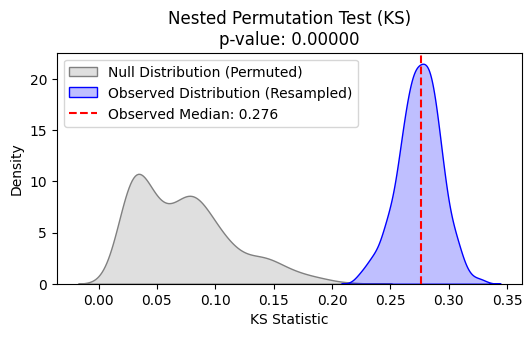

In [40]:
print(f"P-Value (Basal vs. Treatment): {pval1}")
hks1.plot_results()

Now, we will try using the same parameters for the log-normal distribution in both experimental conditions.

In [39]:
params_b2 = {'mean': 0.7, 'sigma': 0.3}
params_t2 = {'mean': 0.7, 'sigma': 0.3}

dataset2 = generate_hierarchical_data(n_basal = 10, 
                                      n_treatment = 7, 
                                      params_basal = params_b2, 
                                      params_treatment = params_t2)

hks2 = HierarchicalPermutationTest(df = dataset2,
                                   value_col = 'variable',
                                   group_col = 'group',
                                   subject_col = 'subject',
                                   cell_col = 'subunit',
                                   metric = 'ks',
                                   replace = True)

pval2 = hks2.run(n_resamples = 500, n_permutations = 500, random_state = 123)

INFO: Auto-detected n_obs_per_cell = 25 (minimum number across the entire dataset).
INFO: Auto-detected n_cells_per_subject = 16 (minimum number across the entire dataset).


Null Distribution: 100%|██████████| 500/500 [03:18<00:00,  2.51it/s]


P-Value (Basal vs. Treatment): 0.538


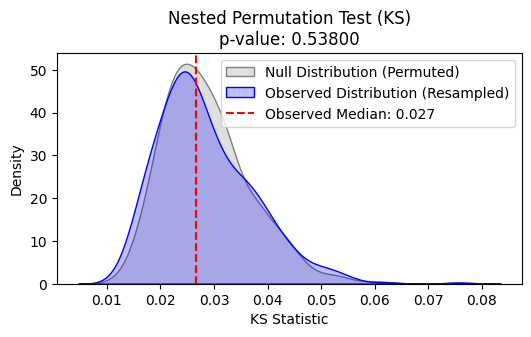

In [41]:
print(f"P-Value (Basal vs. Treatment): {pval2}")
hks2.plot_results()